## Hyperspectral Vision Filter for satellite / birdseye view drone shots
Streaming in pixel data in 2xRow format to be fed to filter kernel and produce an edgemap a 3rd channel captures the NDVI index
Application of Robert's convolution and NDVI index to use as references at night

In [1]:
from PIL import Image as img
from pynq import Overlay, allocate, Xlnk
import pynq.lib.dma
import numpy as np
import matplotlib.pyplot as plt
import time

(405, 540)
(218700,)


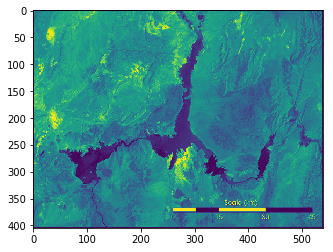

In [2]:
arr_2d = np.array(img.open('lakemead_2004.jpg'))
(h,w) = arr_2d.shape
arr = np.reshape(arr_2d,(h*w))
print(arr_2d.shape)
print(arr.shape)
plt.imshow(arr_2d)

In [3]:
oly = Overlay('design.bit')
oly.download()

In [16]:
LEN = w
oly.edge_filter_0.write(0x10,LEN)
dma0 = oly.IR_Channel1
dma1 = oly.IR_Channel2
dma2 = oly.IR_Channel3
dma3 = oly.OP_Channel2
dma4 = oly.OP_Channel1

In [17]:
out_arr = []
time_str,time_end,time_tot = 0,0,0

for i in range(0,len(arr_2d)-2,2):
    
    in_ch0 = allocate(shape=(LEN,), dtype=np.int32)
    in_ch1 = allocate(shape=(LEN,), dtype=np.int32)
    in_ch2 = allocate(shape=(LEN,), dtype=np.int32) 
    op_ch0 = allocate(shape=(LEN,), dtype=np.int32)
    op_ch1 = allocate(shape=(LEN,), dtype=np.int32)

    in_ch0[:] = arr_2d[i]
    in_ch1[:] = arr_2d[i+1]
    in_ch2[:] = arr_2d[i+2]

    time_str = time.time()
    dma0.sendchannel.transfer(in_ch0)
    dma1.sendchannel.transfer(in_ch1)
    dma2.sendchannel.transfer(in_ch2)
    oly.edge_filter_0.write(0x0,0x1)
    dma3.recvchannel.start()
    dma4.recvchannel.start()
    dma3.recvchannel.transfer(op_ch0)
    dma4.recvchannel.transfer(op_ch1)
    #dma0.sendchannel.wait()
    #dma1.sendchannel.wait()
    #dma2.sendchannel.wait()
    #dma3.recvchannel.wait()
    #dma4.recvchannel.wait()
    time_end = time.time()

    time_tot += (time_end - time_str)
    
    out_arr.append(op_ch0)
    out_arr.append(op_ch1)
    
    del in_ch0
    del in_ch1
    del in_ch2
    del op_ch0
    del op_ch1

In [19]:
len(out_arr[0])

540

In [20]:
len(out_arr)

404

In [21]:
np_out = np.array(out_arr)
np_out.shape

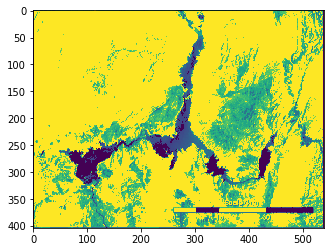

In [24]:
img_filtered = (np.array(out_arr))
plt.imshow(img_filtered.astype('uint8'))

In [25]:
(img.fromarray(img_robert.astype('uint8'))).save('Output.jpg')
print("Total time: ",time_tot)

Total time:  7.588186264038086


##### Issues: need to remember to check the status 0x0,0x30 or shifter by 0x4 for readers.
##### The DMA controls and synchronization in Hostcode and Kernelcode should be properly handled

# Py CV / CPU implementation

In [26]:
import numpy as np
from PIL import Image as img
from matplotlib import pyplot as plt

In [28]:
img_arr = (np.array(img.open('lakemead_2004.jpg'))).astype('int')
img_H = [[0,0],[0,0]]
ver = []

In [29]:
time_str = time.time()
for j in range(0,len(img_arr)-1):
    hor = []
    for i in range(0,img_arr.shape[1]):
        img_H[0][0] = img_H[0][1]
        img_H[0][1] = img_arr[j][i]
        img_H[1][0] = img_H[1][1]
        img_H[1][1] = img_arr[j+1][i]
        Gx = img_H[0][0] - img_H[1][1]
        Gy = img_H[0][1] - img_H[1][0]
        hor.extend([(abs(Gy)+abs(Gy))/2])
    ver.append(hor)
time_end = time.time()
print("CPU time taken: ",(-time_str+time_end))
out_np = np.array(ver)
(img.fromarray(out_np.astype('uint8')).save('Output_cpu.jpg'))

CPU time taken:  9.617496967315674
